In [1]:
import scrapping_with_selenium as sc # scrapping_with_selenium: past project which scrapes data from wuzzuf(check it in my past repo)
import re
import statistics as stat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set_theme(style="whitegrid")


In [ ]:
# the function which scrapes the data for the first  pages
jobs = ["analyst",
        "Data analysis",
        "Data Analyst",
        "Business Analyst",
        "Data Engineer",
        "Data Scientist",
        "Bi developer",
        "Business Intelligence"]

table = sc.scraper("Data", 150, jobs, 0.7)


In [ ]:
table.to_csv("D:\Projects\Data Roles Market\df.csv", index=False)


In [2]:
# read the csv file
df = pd.read_csv("D:\Projects\Data Roles Market\df.csv")
df.head()


,job_id,job_title,company,location,experience,salaries,skill,job_type,open_postions
0,10,Data Analyst,Confidential -,"Heliopolis, Cairo, Egypt",· 2 - 6 Yrs of Exp,Confidential,analytical,Full Time,3
1,10,Data Analyst,Confidential -,"Heliopolis, Cairo, Egypt",· 2 - 6 Yrs of Exp,Confidential,Analyst,Full Time,3
2,10,Data Analyst,Confidential -,"Heliopolis, Cairo, Egypt",· 2 - 6 Yrs of Exp,Confidential,Data,Full Time,3
3,10,Data Analyst,Confidential -,"Heliopolis, Cairo, Egypt",· 2 - 6 Yrs of Exp,Confidential,Data Analyst,Full Time,3
4,11,Data Management Engineer,Ejada -,"Cairo, Egypt",· 3 - 5 Yrs of Exp,Confidential,Computer Science,Full Time,4


In [3]:
# only keep job titles that contains(Data, Analyst & Bi)
df2 = df.copy()
df2 = df2[
    df2["job_title"].str.contains("Data") |
    df2["job_title"].str.contains("Analyst") |
    df2["job_title"].str.contains("BI") |
    df2["job_title"].str.contains("Business Intelligence")
]


In [4]:
# create a list of our conditions
conditions = [
    df2["job_title"].str.contains(
        "Analyst") | df2["job_title"].str.contains("Analysis"),
    df2["job_title"].str.contains("BI"),
    df2["job_title"].str.contains("Engineer"),
    df2["job_title"].str.contains("Scientist")
]

# create a list of the values we want to assign for each condition
values = ['data analyst', 'bi developer', 'data engineer', 'data scientist']

# create a new column and use np.select to assign values to it using our lists as arguments
df2['roles'] = np.select(conditions, values)
df2 = df2[df2.roles.isin(values) == True]


In [5]:
giza_gov = ["Dokki",
"El-Haram",
"Agouza",
"El Ayyat",
"El Badrashein",
"And El Hawamdeya",
"Giza",
"El Omraniya",
"El Wahat El Bahariya",
"El Warraq",
"Sheikh Zayed",
"Smart Village",
"Zamalek",
"El Saff",
"Atfeh",
"Ossim",
"Bulaq",
"Imbaba",
"Kerdasa",
"6th of October"]

# extract cities only
df2["location"] = df2["location"].map(lambda x: x.split(',')[0])

df2["location"] = df2["location"].apply(lambda loc: "Giza" if loc in giza_gov else loc)
# clean companies names & extract experience range
df2["company"] = df2["company"].str.replace(" -", "")
df2["experience"] = df2["experience"].str.replace(" ", "")
df2["experience"] = df2["experience"].str.findall(".(.+?)Y")
df2["experience"] = [''.join(map(str, l)) for l in df2["experience"]]


In [6]:
conditions = [
    df2["experience"].str.contains("^0.*"),
    df2["experience"].str.contains("^1.*"),
    df2["experience"].str.contains("^[23].*"),
    df2["experience"].str.contains("^[45].*"),
    df2["experience"].str.contains("^[67].*")
]

values = ['entry level', 'junior', 'mid level', 'senior', 'team lead']

df2['levels'] = np.select(conditions, values)


In [7]:
def clean_salaries(df, rol, lst):

    conds = [
        (df['roles'] == rol) &
        ((df["salaries"].str.contains("Confidential")) | (df["salaries"].str.contains("Male")) | (df["salaries"].str.contains("Females"))) &
        (df['levels'] == 'entry level'),

        (df['roles'] == rol) &
        ((df["salaries"].str.contains("Confidential")) | (df["salaries"].str.contains("Male")) | (df["salaries"].str.contains("Females"))) &
        (df['levels'] == 'junior'),

        (df['roles'] == rol) &
        ((df["salaries"].str.contains("Confidential")) | (df["salaries"].str.contains("Male")) | (df["salaries"].str.contains("Females"))) &
        (df['levels'] == 'mid level'),

        (df['roles'] == rol) &
        ((df["salaries"].str.contains("Confidential")) | (df["salaries"].str.contains("Male")) | (df["salaries"].str.contains("Females"))) &
        (df['levels'] == 'senior'),

        (df['roles'] == rol) &
        ((df["salaries"].str.contains("Confidential")) | (df["salaries"].str.contains("Male")) | (df["salaries"].str.contains("Females"))) &
        (df['levels'] == 'team lead')
    ]

    for _ in range(len(conds)):
        df['salaries'] = np.where(conds[_], lst[_], df["salaries"])


In [8]:
# replace confidential with avg market salaries lists
sal = {
    "data analyst": [6000, 8000, 10950, 28500, 28500],
    "bi developer": [5625, 8550, 10000, 15000, 20000],
    "data engineer": [9000, 10375, 23000, 30000, 47000],
    "data scientist": [9400, 11000, 19200, 39584, 67815]
}

for i in sal:
    clean_salaries(df2, i, sal[i])


In [9]:
# replace ("number" To "number") expression, to only mean value
df2["salaries"] = df2["salaries"].apply(lambda salary: re.findall(
    (r"\d+"), salary) if type(salary) == str else salary)

df2["salaries"] = df2["salaries"].apply(lambda salary: list(
    map(int, salary)) if type(salary) == list else salary)

df2["salaries"] = df2["salaries"].apply(
    lambda salary: stat.mean(salary) if type(salary) == list else salary)

df2["salaries"] = df2["salaries"].round()


In [10]:
df_noskill = df2.drop(columns=["skill"]).drop_duplicates()


In [11]:
df_skills = df2.copy()
# continue the list of conditions
conditions = [
    (df_skills["skill"].str.contains("(?i)excel")
     | df_skills["skill"].str.contains("(?i)office")
     | df_skills["skill"].str.contains("(?i)Accounting")),

    (df_skills["skill"].str.contains("(?i)power bi")
     | df_skills["skill"].str.fullmatch("(?i)bi")),

    (df_skills["skill"].str.contains("(?i)sql server")
     | df_skills["skill"].str.fullmatch("(?i)ssis")
     | df_skills["skill"].str.fullmatch("(?i)ssas")
     | df_skills["skill"].str.fullmatch("(?i)ssrs")),

    df_skills["skill"].str.fullmatch("(?i)sql"),

    (df_skills["skill"].str.contains("(?i)computer science")
     | df_skills["skill"].str.fullmatch("(?i)coding")
     | df_skills["skill"].str.fullmatch("(?i)software")),

    df_skills["skill"].str.fullmatch("(?i)Tableau"),

    df_skills["skill"].str.fullmatch("(?i)Statistics"),

    df_skills["skill"].str.fullmatch("(?i)python"),

    df_skills["skill"].str.contains("(?i)spark")
]

values = ['excel', 'power bi', 'sql server', 'sql',
          'programming', 'tableau', 'Statistics', 'python', 'spark']

df_skills['skill'] = np.select(conditions, values)
df_skills = df_skills[df_skills.skill.isin(values) == True]


# EDA

#### 1. What is the difference between job oppurtunties for every data role?


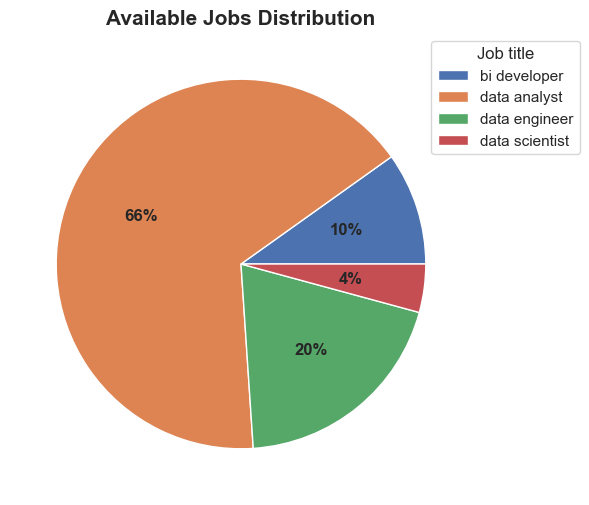

In [12]:

def pie_chart(col, title, legend, legend_title):

    fig, ax = plt.subplots(figsize=(10, 6)
                           , subplot_kw=dict(aspect="equal"))

    wedges, texts, autotexts = ax.pie(col
                                    , autopct= "%1.0f%%")

    plt.setp(autotexts
            , size=12
            , weight="bold")

    ax.set_title(title
                , fontdict={"fontsize": 15, "fontweight": "bold"} )

    ax.legend(wedges, legend
            , title=legend_title
            , bbox_to_anchor=(0.75, 0, 0.5,1))

data = pd.pivot_table(df2[["job_id", "roles", "open_postions"]].drop_duplicates()
                       , values="open_postions"
                       , dropna=True
                       , index="roles"
                       , aggfunc=np.sum).reset_index()   


pie_chart(data.open_postions
          , "Available Jobs Distribution"
          , data.roles
          , "Job title")

#### out of every 10 job postings there are:
- about 6 open positions for data analyst or bussiness analyst

- 2  open positions for a data engineer

- 1  open position for a Bi analyst

#### only **4%** of job postings is for data scientist role which is very low compared to other roles

#### 2. What role that have the most chances for entry levels & juniors?


In [13]:
df_noskill.groupby(["roles", "levels"])["open_postions"] \
    .sum() \
    .reset_index() \
    .query("levels == 'entry level' | levels == 'junior'") \
    .sort_values(by="open_postions", ascending=False) 


,roles,levels,open_postions
4,data analyst,junior,7
3,data analyst,entry level,4
11,data scientist,junior,2


- **31.7%** of job openings is for juniors and entry levels -

- **84.6%** of these jobs is for data analysts

- juniors & entry levels have much less oppurtunities as a data engineer or as a data scientist roles 

#### top 4 cities with job openings 

In [14]:
df_noskill.groupby("location")["open_postions"] \
    .sum() \
    .reset_index() \
    .sort_values(by="open_postions", ascending=False) \
    .head(4) 


,location,open_postions
0,Cairo,19
1,Giza,15
6,Nasr City,13
4,Maadi,10


Most of job opportunities is in cairo & giza governorates 

#### 3. What is the role with the best salaries?


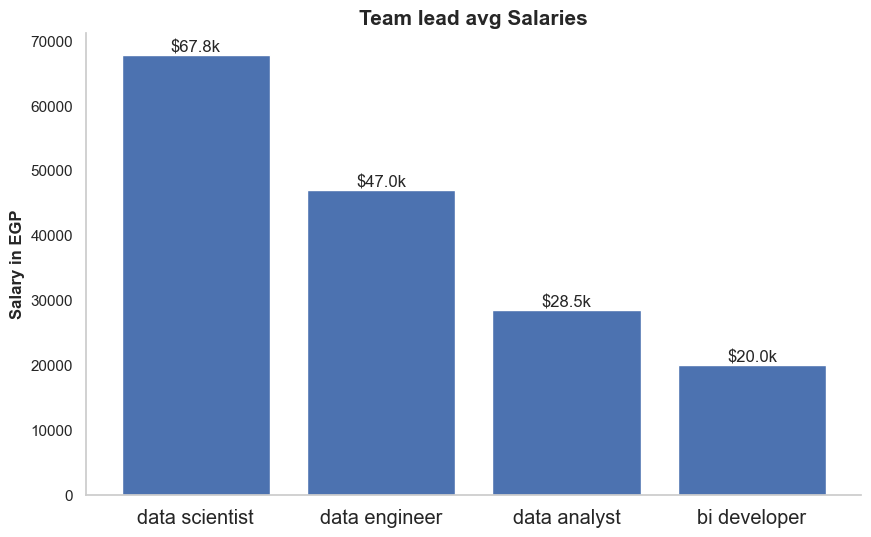

In [36]:
def ths(x):
    'The two args are the value and tick position'
    return '$%1.1fk' % (x * 1e-3)

data = df_noskill.groupby(["roles", "levels"])["salaries"] \
    .median() \
    .reset_index() \
    .query("levels == 'team lead'") \
    .sort_values(by="salaries", ascending=False) 

def bar(x, y, title = "", x_title = "", y_title = "", ticklabel= False):

    fig, ax =  plt.subplots(figsize=(10, 6))

    ax.bar(x, y)

    if ticklabel: 
        ticklabel = [ths(s) for s in data.salaries]
        
        ax.bar_label(ax.containers[0]
                , label_type='edge'
                , fmt= '$%1.1fk'
                , labels=ticklabel)

    ax.set_title(title
                , fontdict={"fontsize": 15, "fontweight": "bold"} )

    ax.set_ylabel(y_title
                , fontdict={"fontsize": 12, "fontweight": "bold"})

    ax.tick_params(axis = "x", labelsize = "large")

    # Hide the right and top spines
    ax.spines[['right', 'top']].set_visible(False)

    ax.grid(False)

bar(data.roles
    , data.salaries
    , title="Team lead avg Salaries"
    , y_title="Salary in EGP"
    , ticklabel=True)

- the salaries data is not comprehensive, since we only have the team lead level that is present in all the roles. 

- its pretty obvious that the **data engineer & scientist** roles get paid double or even triple the amount compared to the other roles.


#### 4. what is the most wanted range of experience in the market?


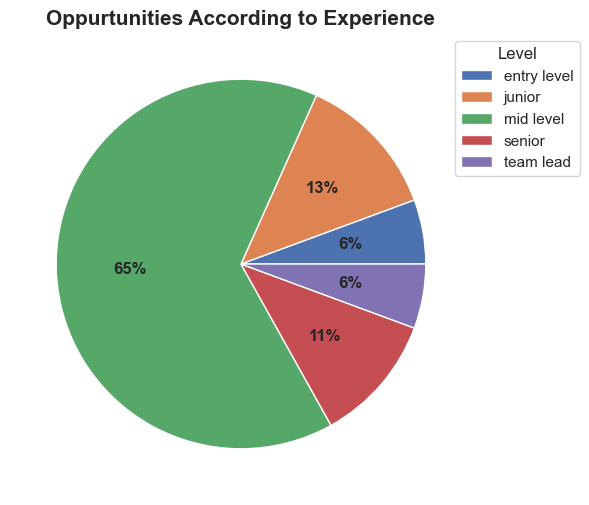

In [23]:
data = pd.pivot_table(df2[["job_id", "levels", "open_postions"]].drop_duplicates()
                       , values="open_postions"
                       , dropna=True
                       , index="levels"
                       , aggfunc=np.sum).reset_index()   

pie_chart(data.open_postions
          , "Oppurtunities According to Experience"
          , data.levels
          , "Level")

most of the vacancies are for the 3+ years of experience employees, representing **65%** of the available opportunities for data professionals.

#### 5. What is the role with the best salaries with 3+ exp level?


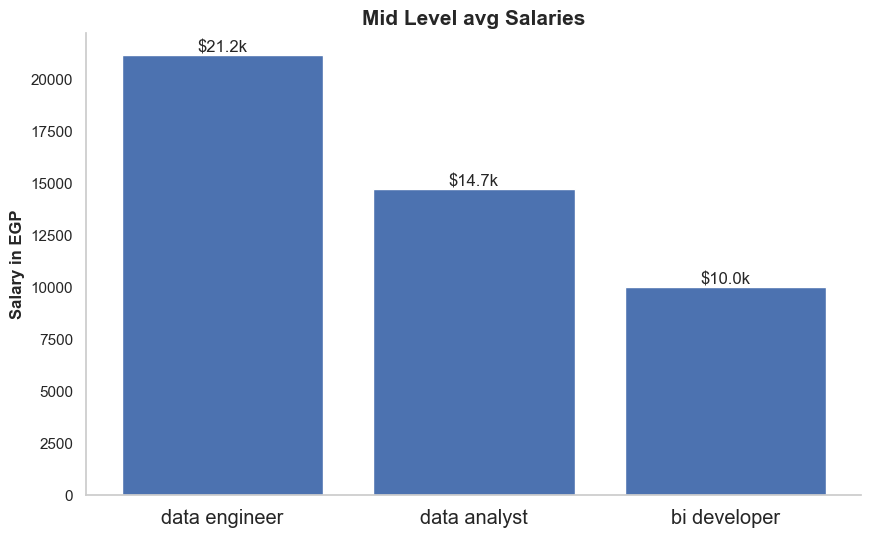

In [37]:
data = df_noskill.groupby(["roles", "levels"])["salaries"] \
    .mean() \
    .reset_index() \
    .query("levels == 'mid level'") \
    .sort_values(by="salaries", ascending=False) 

bar(data.roles
    , data.salaries
    , title="Mid Level avg Salaries"
    , y_title="Salary in EGP"
    , ticklabel=True)


- data engineer gain almost **30%** higher salary than data analyst & **twice** as much as bi developer


#### 6. What are the most common skill tools in jobs description?

In [51]:

data = pd.pivot_table(df_skills[["job_id", "skill", "roles"]].drop_duplicates()
                       , values="skill"
                       , dropna=True
                       , index="roles"
                       , columns="skill"
                       , aggfunc="count"
                       , fill_value=0)

skill,Statistics,excel,power bi,programming,python,sql,sql server,tableau
roles,,,,,,,,
bi developer,0,0,5,4,1,4,3,1
data analyst,3,5,7,18,2,4,1,2
data engineer,0,0,1,4,0,1,1,0
data scientist,1,0,0,0,1,0,0,0


- Due to data inconsistency, skills for data engineers and data scientists are very few. as a result, i will only consider skills for data analysts and bi developers

- Suprisingly, that programming is the most wanted skill even for data analysts & powerbi is more in demand than excel